In [43]:
from pybaseball import statcast, playerid_reverse_lookup, batting_stats
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

# personal function
import sys
sys.path.append("/Users/briandeng/Documents/func")
import plot, search
import importlib

In [44]:
def reload(func):
    importlib.reload(func)

In [45]:
def get_statcast_range_safe(start_date, end_date, freq='30D'):
    all_data = []
    current_start = pd.to_datetime(start_date)
    final_date = pd.to_datetime(end_date)

    while current_start <= final_date:
        current_end = min(current_start + pd.Timedelta(freq), final_date)
        print(f"Fetching {current_start.date()} to {current_end.date()}...")
        try:
            data_chunk = statcast(start_dt=str(current_start.date()), end_dt=str(current_end.date()))
            all_data.append(data_chunk)
        except Exception as e:
            print(f"Failed: {e}")
        current_start = current_end + timedelta(days=1)
    
    return pd.concat(all_data, ignore_index=True)

In [46]:
# get 2024 data
df = get_statcast_range_safe("2024-03-28", "2024-09-29")

Fetching 2024-03-28 to 2024-04-27...
This is a large query, it may take a moment to complete


  0%|          | 0/31 [00:00<?, ?it/s]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  3%|▎         | 1/31 [00:05<02:44,  5.48s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  6%|▋         | 2/31 [00:05<01:07,  2.33s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore'

Fetching 2024-04-28 to 2024-05-28...
This is a large query, it may take a moment to complete


  0%|          | 0/31 [00:00<?, ?it/s]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  3%|▎         | 1/31 [00:05<02:59,  5.97s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  6%|▋         | 2/31 [00:06<01:13,  2.53s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore'

Fetching 2024-05-29 to 2024-06-28...
This is a large query, it may take a moment to complete


  0%|          | 0/31 [00:00<?, ?it/s]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  3%|▎         | 1/31 [00:03<01:48,  3.60s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  6%|▋         | 2/31 [00:05<01:10,  2.44s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore'

Fetching 2024-06-29 to 2024-07-29...
This is a large query, it may take a moment to complete


  0%|          | 0/31 [00:00<?, ?it/s]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  3%|▎         | 1/31 [00:02<01:11,  2.37s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  6%|▋         | 2/31 [00:03<00:52,  1.81s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore'

Fetching 2024-07-30 to 2024-08-29...
This is a large query, it may take a moment to complete


  0%|          | 0/31 [00:00<?, ?it/s]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  3%|▎         | 1/31 [00:03<01:59,  3.97s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  6%|▋         | 2/31 [00:04<01:03,  2.18s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore'

Fetching 2024-08-30 to 2024-09-29...
This is a large query, it may take a moment to complete


  0%|          | 0/31 [00:00<?, ?it/s]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  3%|▎         | 1/31 [00:04<02:07,  4.25s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  6%|▋         | 2/31 [00:04<00:53,  1.85s/it]/Users/briandeng/Library/Python/3.9/lib/python/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore'

In [47]:
# loadt pitch type dictionary
with open("pitch_type.pkl", "rb") as f:
    PITCH_TYPE = pickle.load(f)

In [48]:
# search batter_name function
def search_batter_name(batter):
    """
    Return given batter name.
    """

    batter_info = playerid_reverse_lookup([batter])
    batter_info['batter_name'] = batter_info['name_first'] + ' ' + batter_info['name_last']
    
    return batter_info['batter_name'][0]

# apply to dataframe
batters = df["batter"].unique()
batter_dict = {} # batter name dictionary
for batter in batters:
    batter_dict[batter] = search_batter_name(batter)
df["batter_name"] = df["batter"].map(batter_dict)

In [49]:
# select features
features = ["player_name", "batter_name", "description", "pitch_type", "plate_x", "plate_z", "sz_top", "sz_bot", "release_speed", "release_spin_rate", 
            "pitch_type", "balls", "strikes", "pfx_x", "pfx_z", "stand", "p_throws", "zone",
            "release_extension"]
df = df[features + ["launch_speed", "launch_angle"]]

In [50]:
# drop na
df = df.dropna(subset=features)

In [51]:
print(f"{df.shape[0]} pitches tracked were thrown between 2024 regular season")

704331 pitches tracked were thrown between 2024 regular season


In [53]:
# determine whether a pitch is a ball
def is_ball(pitch):
    """
    Determine whether the given pitch is a ball or not.
    """

    # get data
    plate_x = pitch["plate_x"]
    plate_z = pitch["plate_z"]
    sz_top = pitch["sz_top"]
    sz_bot = pitch["sz_bot"]
    
    # ball radius
    ball = 0.02
    # check x axis
    in_x = abs(plate_x) <= 0.83 + ball
    # check z axis
    in_z = sz_bot - ball <= plate_z <= sz_top + ball

    return not (in_x and in_z)

# filter dataframe with only pitch is a ball
# df = df.dropna()
df = df[df.apply(is_ball, axis=1) == True]

print(f"{df.shape[0]} balls tracked were thrown between 2021 - 2023 regular season")

370489 balls tracked were thrown between 2021 - 2023 regular season


In [54]:
# determine whether the batter swing or not
def is_swing(description):
    """
    Determine whether the batter swing or take based on given description.
    1 is swing, and 0 is take.
    """

    # swing
    swing_keywords = [
        'swinging_strike', 'swinging_strike_blocked',
        'foul', 'foul_tip', 'foul_bunt',
        'hit_into_play', 'hit_into_play_no_out',
        'hit_into_play_score', 'bunt_foul_tip', 'missed_bunt'
    ]
    # take
    take_keywords = [
        'ball', 'called_strike', 'blocked_ball', 'pitchout', 'hit_by_pitch'
    ]

    # determine result
    if description in swing_keywords:
        return 1
    else:
        return 0

In [55]:
# apply to dataframe
df["swing"] = df["description"].apply(is_swing)

In [56]:
print("number of swing and take")
df["swing"].value_counts()

number of swing and take


swing
0    260009
1    110480
Name: count, dtype: int64

In [57]:
# normalize plate_z
def normalize_plate_z(pitch):
    """
    Normalize given pitch plate z value.
    """

    # get values
    plate_z = pitch["plate_z"]
    sz_top = pitch["sz_top"]
    sz_bot = pitch["sz_bot"]

    # normalize z
    norm_z = (plate_z - sz_bot) / (sz_top - sz_bot)

    return norm_z

In [58]:
# apply plate_z normalization to dataframe
df["norm_plate_z"] = df.apply(normalize_plate_z, axis=1)

In [60]:
# save test data
df.to_csv("cleaned_test_data.csv")

In [19]:
# prepare data function
def prepare_data(df, label=1):
    """
    With given dataframe, return X and y if label is equal to 1.
    """
    
    # label pitch_type
    df["label_pitch_type"] = df["pitch_type"].map(PITCH_TYPE)
    df["label_pitch_type"] = df["label_pitch_type"].astype(int)

    # determine it is same or different side
    df["same_side"] = (df["stand"] == df["p_throws"]).astype(int)

    # drop pitchout rows
    df = df[df["description"] != "pitchout"]

    # normalize numerical features
    numerical_features = ["plate_x", "norm_plate_z", "release_speed", "release_spin_rate", 
                          "pfx_x", "pfx_z", "release_extension"]
    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    # select data
    features = ["plate_x", "norm_plate_z", "release_speed", "release_spin_rate", "pfx_x", "pfx_z", 
                "balls", "strikes", "same_side", "label_pitch_type",
                "release_extension"]
    X = df[features].values
    y = df["swing"].values

    return X, y, len(features), df

In [20]:
# MLP model
class MLP(nn.Module):
    def __init__(self, input_dim=14):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        logits = self.output(x)

        return logits

In [21]:
# set device
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "mps"

In [22]:
# prepare data
X, y, input_dim, df = prepare_data(df)

# convert type
X = X.astype(np.float32)
y = y.astype(np.float32)

# train model with all data
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# create model
model = MLP(input_dim=input_dim).to(device)

# load model
model = MLP(input_dim=input_dim)
model.load_state_dict(torch.load("swing_prob_model.pt"))

/var/folders/r1/fdb0tbq57qj3ww3lz_lh0xf00000gn/T/ipykernel_929/300832053.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_features] = scaler.fit_transform(df[numerical_features])


<All keys matched successfully>

In [23]:
# compute probability of swinging
model = model.to(device)
model.eval()
with torch.no_grad():
    # get predicted value
    logits = model(X_tensor)
    y_prob = torch.sigmoid(logits).cpu().numpy().flatten()
    y_test = y_tensor.cpu().numpy()
    y_pred = [round(i) for i in y_prob]

In [24]:
# compute contact quality for each pitch
def compute_cq(pitch):
    """
    With given pitch, calculate its contact quality.
    """

    # check swing or not
    if pitch["swing"] == 0:
        cq = 0
        return cq

    # get description
    description = pitch["description"]

    if description in ["swinging_strike", "swinging_strike_blocked", "foul", "foul_tip", "foul_bunt", "missed_bunt",
                       "bunt_foul_pitch"]: # swing and miss or foul
        cq = 0
    else:
        # get values
        ev = pitch["launch_speed"] # exit velocity
        la = pitch["launch_angle"] # launch angle
        try:
            # compute scores
            ev_score = min(1, max(0, (ev - 70) / 28))
            la_score = max(0, 1 - abs(la - 20) / 20)

            # compute cq
            cq = ev_score * la_score
        except TypeError:
            cq = None

    return cq

# apply function to dataframe
df["cq"] = df.apply(compute_cq, axis=1)

In [25]:
# create testing dataframe
test_df = pd.DataFrame()
test_df["batter_name"] = df["batter_name"]
test_df["actual_result"] = df["swing"]
test_df["pred_result"] = y_prob
test_df["cq"] = df["cq"]

In [26]:
# ds function
def compute_ds(pitch):
    """
    Compute discipline score.
    """

    # get values
    r = pitch["actual_result"] # actual result
    ps = pitch["pred_result"] # predict result

    # compute ds
    ds = (-1)**r * (r * (1 - ps) + (1 - r) * ps)

    return ds

# apply to function
test_df["ds"] = test_df.apply(compute_ds, axis=1)

# compute ads
test_df["ads"] = test_df["ds"] + test_df["cq"]

In [27]:
test_df.head()

,batter_name,actual_result,pred_result,cq,ds,ads
1,ozzie albies,1,0.983629,0.0,-0.016371,-0.016371
2,ozzie albies,1,0.931983,0.0,-0.068017,-0.068017
4,ozzie albies,0,0.313482,0.0,0.313482,0.313482
5,ozzie albies,0,0.614130,0.0,0.614130,0.614130
6,ozzie albies,0,0.088130,0.0,0.088130,0.088130


In [28]:
mean_df = test_df.groupby("batter_name")[["ds", "ads"]].mean()
mean_df = mean_df.reset_index()

In [29]:
mean_df.sort_values(by="ds", ascending=False)

,batter_name,ds,ads
553,scott mcgough,0.698199,0.698199
85,brian anderson,0.490477,0.490477
154,david bañuelos,0.448295,0.448295
465,myles straw,0.405094,0.405094
419,marco luciano,0.348674,0.348674
...,...,...,...
496,orelvis martinez,-0.055827,-0.055827
346,josé azocar,-0.070390,-0.057634
202,eric yang,-0.094860,-0.094860
125,cj alexander,-0.128074,-0.123431


In [30]:
batting_df = batting_stats(2024)

In [31]:
# filter player who have at least 150 PA
batting_df["Name"] = batting_df["Name"].str.lower() # change name to lower case
qualified_player = list(batting_df[batting_df["PA"] >= 250]["Name"].values)

In [32]:
# filter testing dataframe
mean_df = mean_df[mean_df["batter_name"].isin(qualified_player)]

In [33]:
mean_df

,batter_name,ds,ads
1,aaron judge,0.301056,0.307357
8,adley rutschman,0.146096,0.163181
13,alec bohm,0.185664,0.199252
14,alec burleson,0.041969,0.061424
18,alex bregman,0.221214,0.231561
...,...,...,...
629,willy adames,0.177691,0.182936
632,wyatt langford,0.236501,0.240165
635,yainer diaz,0.013592,0.030200
645,zach neto,0.141531,0.154262


In [34]:
# add columns to mean_df
right_df = batting_df[["Name", "O-Swing%", "BB", "SO", "AB", "PA", "AVG"]]
right_df["batter_name"] = right_df["Name"]
result_df = pd.merge(mean_df, right_df, on=["batter_name"], how="left")

/var/folders/r1/fdb0tbq57qj3ww3lz_lh0xf00000gn/T/ipykernel_929/4027658770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df["batter_name"] = right_df["Name"]


In [35]:
# add interested feature
result_df["BB/SO"] = result_df["BB"] / result_df["SO"]
result_df["BB_rate"] = result_df["PA"] / result_df["BB"]

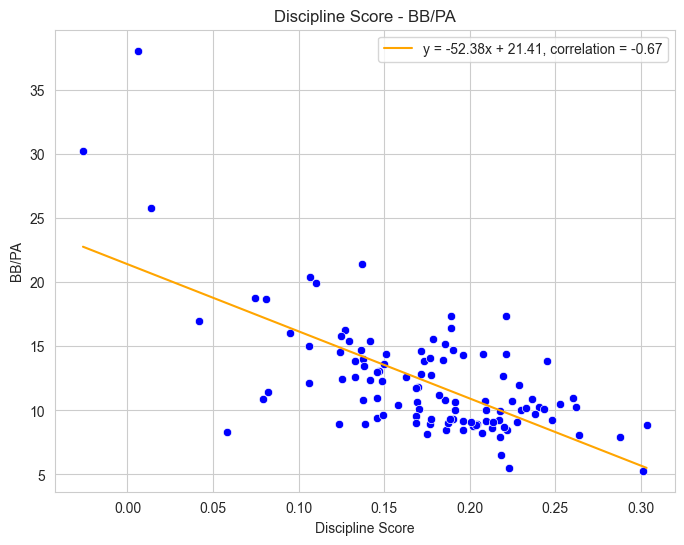

In [36]:
reload(plot)
plot.scatter_plot(data=result_df, x="ds", y="BB_rate", xlabel="Discipline Score", ylabel="BB/PA", corr=True)

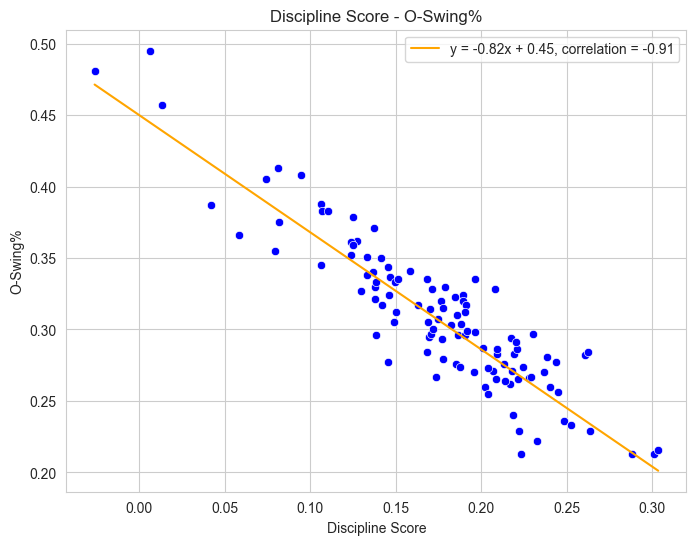

In [37]:
plot.scatter_plot(data=result_df, x="ds", y="O-Swing%", xlabel="Discipline Score", corr=True)

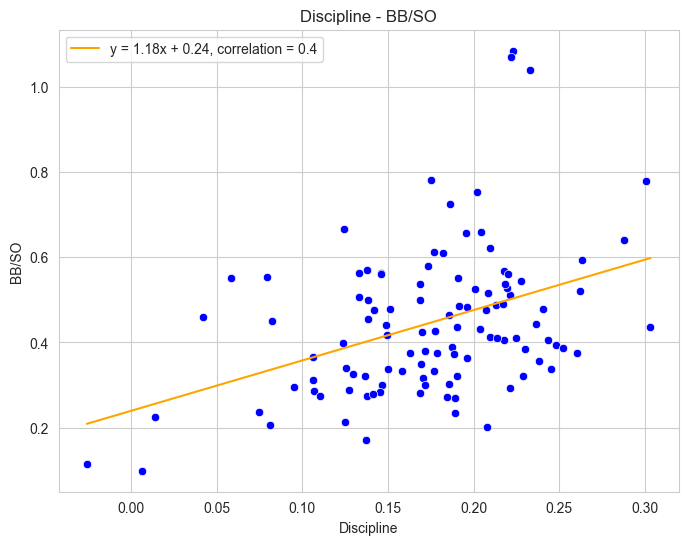

In [38]:
plot.scatter_plot(data=result_df, x="ds", y="BB/SO", xlabel="Discipline", corr=True)

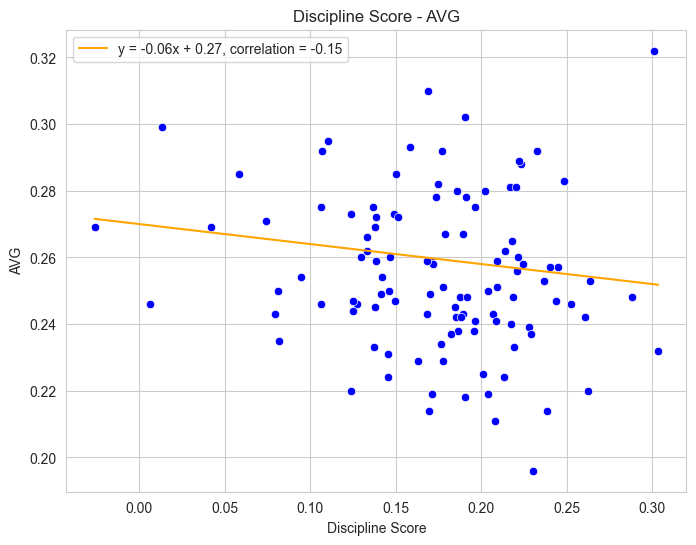

In [39]:
plot.scatter_plot(data=result_df, x="ds", y="AVG", xlabel="Discipline Score", corr=True)

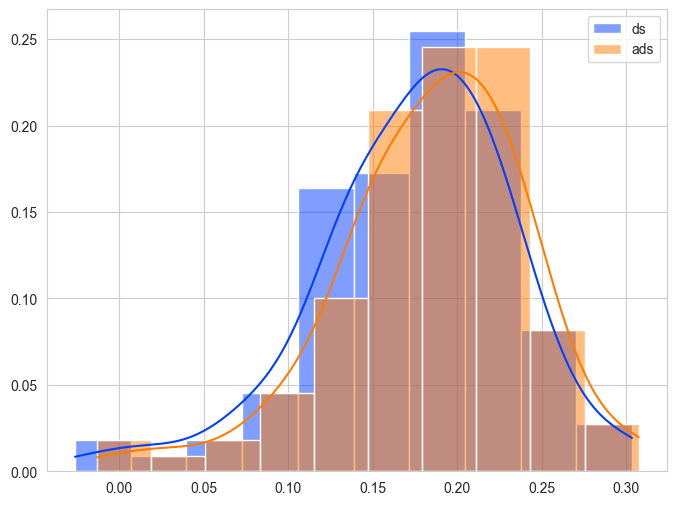

In [42]:
reload(plot)
plot.hist_plot(data=result_df, features=["ds", "ads"])

In [41]:
reload(search)
search.rank(data=result_df, by="O-Swing%", features=["batter_name", "ds", "ads", "BB_rate", "O-Swing%"], ascending=True)

,batter_name,ds,ads,BB_rate,O-Swing%
0,aaron judge,0.301056,0.307357,5.293233,0.213
59,juan soto,0.223138,0.232310,5.527132,0.213
54,jonathan india,0.288163,0.293880,7.962500,0.213
7,andrew mccutchen,0.303438,0.304886,8.879310,0.216
96,steven kwan,0.232863,0.241880,10.188679,0.222
75,mookie betts,0.221899,0.241037,8.459016,0.229
51,jesse winker,0.263658,0.268469,8.063492,0.229
97,taylor ward,0.252530,0.257159,10.523810,0.233
92,seiya suzuki,0.248159,0.255397,9.285714,0.236
63,kyle schwarber,0.218411,0.223138,6.528302,0.240
